In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.preprocessing import StandardScaler, PolynomialFeatures
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LinearRegression
from sklearn.ensemble import RandomForestRegressor, GradientBoostingRegressor
from sklearn.metrics import mean_squared_error
import warnings
import logging
from datetime import datetime
from abc import ABC, abstractmethod
import optuna
from sklearn.model_selection import KFold
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score

# Seaborn
rc = {
    #FAEEE9
    "axes.facecolor": "#243139",
    "figure.facecolor": "#243139",
    "axes.edgecolor": "#000000",
    "grid.color": "#000000",
    "font.family": "arial",
    "axes.labelcolor": "#FFFFFF",
    "xtick.color": "#FFFFFF",
    "ytick.color": "#FFFFFF",
    "grid.alpha": 0.4
}
sns.set(rc=rc)

# Useful line of code to set the display option so we could see all the columns in pd dataframe
pd.set_option('display.max_columns', None)

# Suppress warnings
warnings.filterwarnings("ignore", category=UserWarning)
warnings.filterwarnings("ignore", category=FutureWarning)
warnings.filterwarnings("ignore", category=RuntimeWarning)



In [2]:
# Load the datasets
train_df = pd.read_csv("/kaggle/input/playground-series-s5e9/train.csv")
test_df = pd.read_csv("/kaggle/input/playground-series-s5e9/test.csv")
sample_submission_df = pd.read_csv("/kaggle/input/playground-series-s5e9/sample_submission.csv")

print('Train data shape:', train_df.shape)
print('Test data shape:', test_df.shape)

# Display first few rows of the training data
print('\nTrain Data Head:')
train_df.head()


Train data shape: (524164, 11)
Test data shape: (174722, 10)

Train Data Head:


,id,RhythmScore,AudioLoudness,VocalContent,AcousticQuality,InstrumentalScore,LivePerformanceLikelihood,MoodScore,TrackDurationMs,Energy,BeatsPerMinute
0,0,0.603610,-7.636942,0.023500,0.000005,0.000001,0.051385,0.409866,290715.6450,0.826267,147.53020
1,1,0.639451,-16.267598,0.071520,0.444929,0.349414,0.170522,0.651010,164519.5174,0.145400,136.15963
2,2,0.514538,-15.953575,0.110715,0.173699,0.453814,0.029576,0.423865,174495.5667,0.624667,55.31989
3,3,0.734463,-1.357000,0.052965,0.001651,0.159717,0.086366,0.278745,225567.4651,0.487467,147.91212
4,4,0.532968,-13.056437,0.023500,0.068687,0.000001,0.331345,0.477769,213960.6789,0.947333,89.58511


In [3]:
# Display basic info of the training data
print('\nTrain Data Info:')
train_df.info()

# Display descriptive statistics of the training data
print('\nTrain Data Description:')
train_df.describe()


Train Data Info:
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 524164 entries, 0 to 524163
Data columns (total 11 columns):
 #   Column                     Non-Null Count   Dtype  
---  ------                     --------------   -----  
 0   id                         524164 non-null  int64  
 1   RhythmScore                524164 non-null  float64
 2   AudioLoudness              524164 non-null  float64
 3   VocalContent               524164 non-null  float64
 4   AcousticQuality            524164 non-null  float64
 5   InstrumentalScore          524164 non-null  float64
 6   LivePerformanceLikelihood  524164 non-null  float64
 7   MoodScore                  524164 non-null  float64
 8   TrackDurationMs            524164 non-null  float64
 9   Energy                     524164 non-null  float64
 10  BeatsPerMinute             524164 non-null  float64
dtypes: float64(10), int64(1)
memory usage: 44.0 MB

Train Data Description:


,id,RhythmScore,AudioLoudness,VocalContent,AcousticQuality,InstrumentalScore,LivePerformanceLikelihood,MoodScore,TrackDurationMs,Energy,BeatsPerMinute
count,524164.000000,524164.000000,524164.000000,524164.000000,524164.000000,524164.000000,524164.000000,524164.000000,524164.000000,524164.000000,524164.000000
mean,262081.500000,0.632843,-8.379014,0.074443,0.262913,0.117690,0.178398,0.555843,241903.692949,0.500923,119.034899
std,151313.257586,0.156899,4.616221,0.049939,0.223120,0.131845,0.118186,0.225480,59326.601501,0.289952,26.468077
min,0.000000,0.076900,-27.509725,0.023500,0.000005,0.000001,0.024300,0.025600,63973.000000,0.000067,46.718000
25%,131040.750000,0.515850,-11.551933,0.023500,0.069413,0.000001,0.077637,0.403921,207099.876625,0.254933,101.070410
50%,262081.500000,0.634686,-8.252499,0.066425,0.242502,0.074247,0.166327,0.564817,243684.058150,0.511800,118.747660
75%,393122.250000,0.739179,-4.912298,0.107343,0.396957,0.204065,0.268946,0.716633,281851.658500,0.746000,136.686590
max,524163.000000,0.975000,-1.357000,0.256401,0.995000,0.869258,0.599924,0.978000,464723.228100,1.000000,206.037000


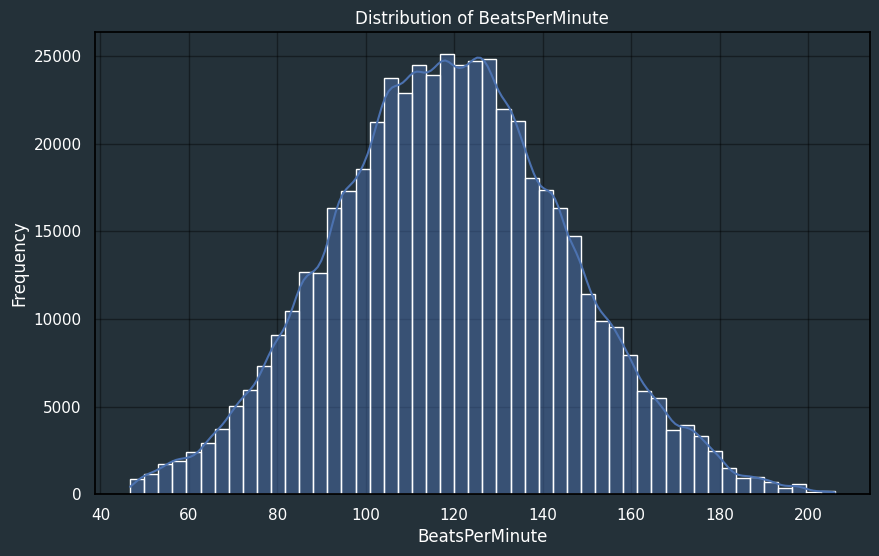

In [4]:
# Visualize the distribution of the target variable (BeatsPerMinute)
plt.figure(figsize=(10, 6))
sns.histplot(train_df['BeatsPerMinute'], kde=True, bins=50)
plt.title('Distribution of BeatsPerMinute', color='white')
plt.xlabel('BeatsPerMinute')
plt.ylabel('Frequency')
plt.show()
plt.close()

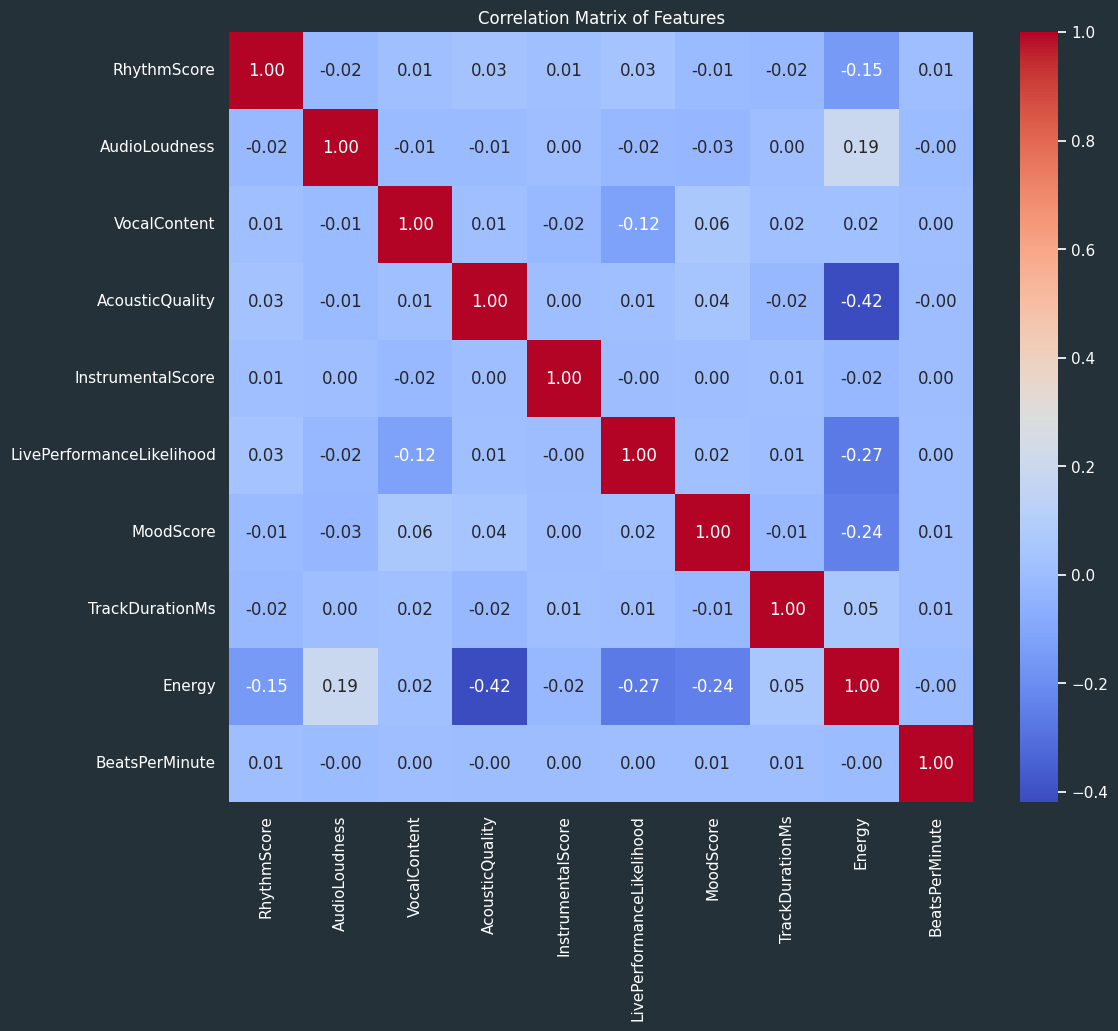

In [5]:
# Visualize correlations
plt.figure(figsize=(12, 10))
sns.heatmap(train_df.drop("id", axis=1).corr(), annot=True, cmap="coolwarm", fmt=".2f")
plt.title("Correlation Matrix of Features", color='white')
plt.show()
plt.close()


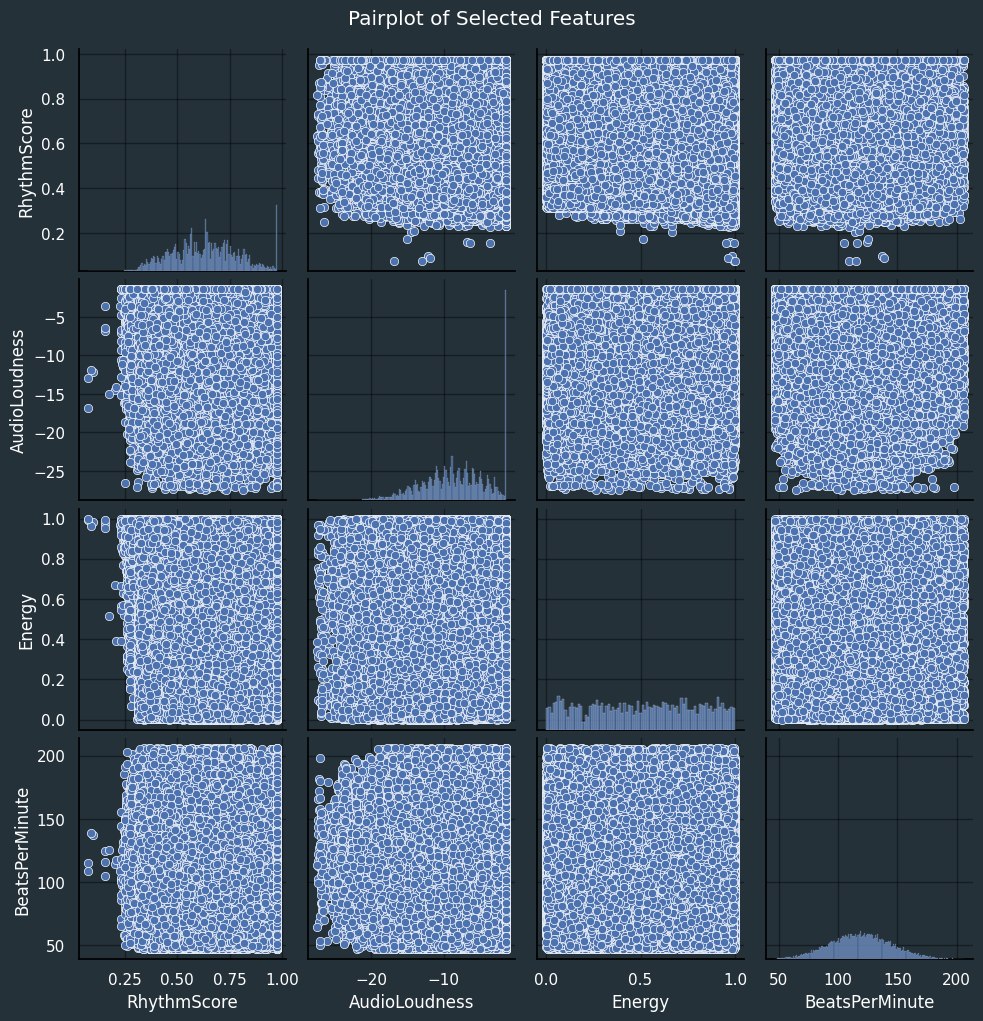

In [6]:

# Pairplot for a subset of features and target (can be slow for many features, select carefully)
# For now, let's pick a few features that might be interesting based on the correlation matrix or domain knowledge.
# For example, RhythmScore, AudioLoudness, Energy, and BeatsPerMinute
selected_features = ["RhythmScore", "AudioLoudness", "Energy", "BeatsPerMinute"]
sns.pairplot(train_df[selected_features])
plt.suptitle("Pairplot of Selected Features", y=1.02, color='white') # Adjust suptitle to not overlap
plt.show()
plt.close()

In [7]:

# Combine train and test for consistent preprocessing
# Store \'id\' and \'BeatsPerMinute\' for later
train_ids = train_df["id"]
test_ids = test_df["id"]
target = train_df["BeatsPerMinute"]

# Drop id and target from training data for feature engineering
train_df = train_df.drop(["id", "BeatsPerMinute"], axis=1)
test_df = test_df.drop("id", axis=1)

# Align columns - very important if feature engineering creates different columns in train/test
# For now, assuming same columns, but this is a placeholder for more complex FE
common_cols = list(set(train_df.columns) & set(test_df.columns))
train_df = train_df[common_cols]
test_df = test_df[common_cols]

# Feature Engineering - Example: Interaction terms and Polynomial Features
# This is a starting point, more sophisticated features can be added based on EDA

# Create some interaction features (multiplication)
for col1 in ["RhythmScore", "Energy"]:
    for col2 in ["AudioLoudness", "MoodScore"]:
        if col1 != col2:
            train_df[f"{col1}_x_{col2}"] = train_df[col1] * train_df[col2]
            test_df[f"{col1}_x_{col2}"] = test_df[col1] * test_df[col2]

# Create polynomial features for a few selected columns
poly = PolynomialFeatures(degree=2, include_bias=False)
poly_features = ["RhythmScore", "Energy", "AudioLoudness"]

# Apply polynomial features to train data
poly_train_df = pd.DataFrame(poly.fit_transform(train_df[poly_features]), columns=poly.get_feature_names_out(poly_features))
train_df = pd.concat([train_df.reset_index(drop=True), poly_train_df], axis=1)

# Apply polynomial features to test data
poly_test_df = pd.DataFrame(poly.transform(test_df[poly_features]), columns=poly.get_feature_names_out(poly_features))
test_df = pd.concat([test_df.reset_index(drop=True), poly_test_df], axis=1)

# Scaling numerical features
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(train_df)
X_test_scaled = scaler.transform(test_df)

X_train = pd.DataFrame(X_train_scaled, columns=train_df.columns)
X_test = pd.DataFrame(X_test_scaled, columns=test_df.columns)

y_train = target

print("\nShape after feature engineering - Train:", X_train.shape)
print("Shape after feature engineering - Test:", X_test.shape)

# Save processed data for modeling phase
#X_train.to_csv("X_train_processed.csv", index=False)
#X_test.to_csv("X_test_processed.csv", index=False)
#y_train.to_csv("y_train.csv", index=False)

#print("Processed data saved: X_train_processed.csv, X_test_processed.csv, y_train.csv")




Shape after feature engineering - Train: (524164, 22)
Shape after feature engineering - Test: (174722, 22)


In [8]:
X_train.head()

,VocalContent,RhythmScore,AcousticQuality,MoodScore,TrackDurationMs,LivePerformanceLikelihood,Energy,AudioLoudness,InstrumentalScore,RhythmScore_x_AudioLoudness,RhythmScore_x_MoodScore,Energy_x_AudioLoudness,Energy_x_MoodScore,RhythmScore,Energy,AudioLoudness,RhythmScore^2,RhythmScore Energy,RhythmScore AudioLoudness,Energy^2,Energy AudioLoudness,AudioLoudness^2
0,-1.020114,-0.186320,-1.178322,-0.647405,0.822767,-1.074691,1.122062,0.160753,-0.892636,0.214070,-0.614077,-0.681985,0.398430,-0.186320,1.122062,0.160753,-0.296589,0.964538,0.214070,1.168911,-0.681985,-0.377470
1,-0.058541,0.042116,0.815779,0.422064,-1.304377,-0.066641,-1.226143,-1.708885,1.757555,-1.543674,0.382710,0.452956,-0.880293,0.042116,-1.226143,-1.708885,-0.079122,-1.112388,-1.543674,-1.055064,0.452956,1.968600
2,0.726325,-0.754022,-0.399847,-0.585321,-1.136222,-1.259230,0.426774,-1.640859,2.549397,-0.878029,-0.787033,-1.733687,0.011229,-0.754022,0.426774,-1.640859,-0.782723,0.056880,-0.878029,0.185605,-1.733687,1.853542
3,-0.430095,0.647674,-1.170947,-1.228925,-0.275361,-0.778712,-0.046407,1.521162,0.318762,1.310441,-0.865923,0.943149,-0.664263,0.647674,-0.046407,1.521162,0.558041,0.244277,1.310441,-0.327329,0.943149,-1.019747
4,-1.020114,-0.636554,-0.870498,-0.346257,-0.471004,1.294126,1.539602,-1.013259,-0.892636,-0.498707,-0.571367,-2.425075,0.995588,-0.636554,1.539602,-1.013259,-0.688488,0.996049,-0.498707,1.890734,-2.425075,0.897815


In [9]:
X_test.head()

,VocalContent,RhythmScore,AcousticQuality,MoodScore,TrackDurationMs,LivePerformanceLikelihood,Energy,AudioLoudness,InstrumentalScore,RhythmScore_x_AudioLoudness,RhythmScore_x_MoodScore,Energy_x_AudioLoudness,Energy_x_MoodScore,RhythmScore,Energy,AudioLoudness,RhythmScore^2,RhythmScore Energy,RhythmScore AudioLoudness,Energy^2,Energy AudioLoudness,AudioLoudness^2
0,-1.020114,-1.420214,-0.134470,0.481099,1.028171,0.788482,-0.262305,-1.823128,-0.796403,-0.476702,-0.466639,-0.919476,0.102802,-1.420214,-0.262305,-1.823128,-1.254423,-0.696638,-0.476702,-0.519318,-0.919476,2.166875
1,1.349161,-1.082049,-0.919627,1.213896,-0.335567,-0.683456,1.190119,1.521162,1.063766,1.422194,0.192973,0.803173,2.301525,-1.082049,1.190119,1.521162,-1.028312,0.416934,1.422194,1.279843,0.803173,-1.019747
2,1.870453,0.342422,0.111648,-1.112582,1.952251,1.248127,-1.265230,1.085323,0.707083,0.911004,-0.838416,1.003518,-1.162079,0.342422,-1.265230,1.085323,0.225843,-1.117150,0.911004,-1.065711,1.003518,-0.911625
3,0.881993,1.612179,-1.178322,-0.302036,0.503766,-0.371990,-0.636160,0.602434,1.966072,0.108174,0.475650,0.623769,-0.567445,1.612179,-0.636160,0.602434,1.754847,-0.153444,0.108174,-0.789461,0.623769,-0.684326
4,1.034398,0.028986,1.237720,0.157018,0.603859,-1.303869,-0.068480,0.283967,-0.369680,0.245795,0.149974,0.155199,0.114235,0.028986,-0.068480,0.283967,-0.091962,-0.018808,0.245795,-0.348166,0.155199,-0.472581


### Modeling

In [10]:
model_lr = LinearRegression()
model_rf = RandomForestRegressor(random_state=42, n_estimators=300, n_jobs=-1) 
model_gb = GradientBoostingRegressor(random_state=42, n_estimators=398) 

models = {
    "Linear Regression": model_lr,
    "Random Forest": model_rf,
    "Gradient Boosting": model_gb
}

predictions = {}

# Train models and make predictions
for name, model in models.items():
    print(f"\nTraining {name}...")
    try:
        model.fit(X_train, y_train)
        train_preds = model.predict(X_train)
        test_preds = model.predict(X_test)
        predictions[name] = test_preds
        rmse = np.sqrt(mean_squared_error(y_train, train_preds))
        print(f"{name} Train RMSE: {rmse:.4f}")
    except Exception as e:
        print(f"Error training {name}: {e}")

# Simple Averaging Ensemble
print("\nCreating Ensemble Predictions...")
ensemble_preds = np.mean([preds for preds in predictions.values()], axis=0)

# Save individual model predictions and ensemble predictions
for name, preds in predictions.items():
    filename = name.replace(" ", "_") + "_predictions.csv"
    pd.DataFrame(preds, columns=["BeatsPerMinute"]).to_csv(filename, index=False)
    print(f"Saved {name} predictions to {filename}")

pd.DataFrame(ensemble_preds, columns=["BeatsPerMinute"]).to_csv("ensemble_predictions.csv", index=False)
print("Saved ensemble predictions to ensemble_predictions.csv")

# Generate sample submission file for ensemble
sample_submission_df["BeatsPerMinute"] = ensemble_preds
sample_submission_df.to_csv("submission.csv", index=False)
print("Generated submission.csv with ensemble predictions.")


Training Linear Regression...
Linear Regression Train RMSE: 26.4651

Training Random Forest...
Random Forest Train RMSE: 9.8496

Training Gradient Boosting...
Gradient Boosting Train RMSE: 26.3789

Creating Ensemble Predictions...
Saved Linear Regression predictions to Linear_Regression_predictions.csv
Saved Random Forest predictions to Random_Forest_predictions.csv
Saved Gradient Boosting predictions to Gradient_Boosting_predictions.csv
Saved ensemble predictions to ensemble_predictions.csv
Generated submission.csv with ensemble predictions.
